In [56]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure, io
import matplotlib.pyplot as plt
import mahotas as mh
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

In [57]:
def parse_filename(filepath):
    basename, ext = os.path.splitext(os.path.basename(filepath))

    comps = basename.split('_')
    size = tuple([int(v) for v in comps[-1:][0].split('x')])
    bits = int(re.findall('\d+', comps[-2:-1][0])[0])
    name = '_'.join(comps[:-2])

    return name, bits, size, ext

In [58]:
def segment_data(filepath):
    data = open_data(filepath)
    # apply 3D median filter 2x2x2
    # calculate Reyni thresholding
    # crop

In [59]:
def open_data(filepath):
    _, glob_ext = os.path.splitext(os.path.basename(filepath))
    data = None

    if glob_ext == '.raw':
        name, bits, size, ext = parse_filename(filepath)
        data_type = np.float32 if bits == 32 else np.uint8
        data = np.memmap(filepath, dtype=data_type, shape=tuple(reversed(size)), mode='r')
    elif glob_ext == '.nii.gz' or glob_ext == '.nii' or glob_ext == '.gz':
        data = nib.load(filepath).get_data()
    elif glob_ext == '.tif':
        data = io.imread(filepath)
    else:
        print 'Incorrent file format, or filename.'

    return data

In [69]:
def save_fig(fig, output_filepath):
    output_path, filename = os.path.split(output_filepath)
        
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    print output_filepath
    
    plt.tight_layout()
    fig.savefig(output_filepath)

In [61]:
def write_as_raw(data, sample_name, output_dir, prefix=None):
    bits = -1
    if data.dtype == np.int32 or data.dtype == np.float32:
        bits = 32
    elif data.dtype == np.uint8 or data.dtype == np.bool:
        bits = 8

    size = data.shape[::-1]
    output_filename = '{0}_{1}bit_{2}x{3}x{4}.raw'.format(sample_name, bits, *size) if prefix is None \
                        else '{0}_{1}_{2}bit_{3}x{4}x{5}.raw'.format(sample_name, prefix, bits, *size)
    data.tofile(os.path.join(output_dir, output_filename))


In [62]:
_MEASUREMENTS = {
    'Label': 'label',
    'Area': 'area',
    'Perimeter': 'perimeter'
}

_MEASUREMENTS_VALS = _MEASUREMENTS.values()

def object_counter(stack_binary_data):
    print 'Object counting - Labeling...'
    labeled_stack, num_labels = ndi.measurements.label(stack_binary_data)
    objects_stats = pd.DataFrame(columns=_MEASUREMENTS_VALS)
    
    print 'Object counting - Stats gathering...'
    for slice_idx in np.arange(labeled_stack.shape[0]):
        for region in measure.regionprops(labeled_stack[slice_idx]):
            objects_stats = objects_stats.append({_measure: region[_measure] \
                                        for _measure in _MEASUREMENTS_VALS}, \
                                            ignore_index=True)
            
    print 'Object counting - Stats grouping...'
    objects_stats = objects_stats.groupby('label', as_index=False).sum()

    return objects_stats, labeled_stack

In [63]:
def estimate_particles(samples, output_dir):
    for sample_name,params in samples['samples'].items():
        if 'particles' in params:
            print '###### Processing of {0}'.format(sample_name)

            print 'Data processing - Opening...'
            input_data = open_data(os.path.join(samples['input_dir'], params['particles'][0]))
            output_path = os.path.join(output_dir, sample_name)

            objects_stats, labeled_data = object_counter(input_data)

            print 'Data storing - Stats and data saving...'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            objects_stats.to_csv(os.path.join(output_path, 'particles_stats_{0}.csv'.format(sample_name)))

In [64]:
def estimate_porosity(samples, output_dir):
    for sample_name,sample_info in samples['samples'].items():
        print '###### Processing of {0}'.format(sample_name)
        
        output_path = os.path.join(output_dir, sample_name)
        total_volume, material_volume = None, 0
        
        for structure_type, data_params in sample_info.items():
            print 'Data processing - Opening...'
            
            input_data = open_data(os.path.join(samples['input_dir'], data_params[0]))
            
            if total_volume is None:
                total_volume = input_data.size
                
            material_volume += np.count_nonzero(input_data)
                
        print 'Data storing - Stats and data saving...'
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        porosity = material_volume / float(total_volume)
        print 'Porosity :{0}'.format(porosity)
        
        np.savetxt(os.path.join(output_path, 'porosity_{0}.txt'.format(sample_name)), [porosity])

In [65]:
samples_data = {
    'input_dir': './samples/polymer_data/cropped',
    'samples': {
        'PCL_SiHA_cl': {
            'particles': ('PCL9%_Si-HA10%_cl/analysis/particles_PCL9%_Si-HA10%_cl_32bit_800x800x484.tif', np.uint8, (484,800,800)),
            'fibers': ('PCL9%_Si-HA10%_cl/analysis/fibers_PCL9%_Si-HA10%_cl_8bit_800x800x442.raw', np.uint8, (442,800,800))
        },
        'PCL_SiHA_wa': {
            'particles':('PCL9%_Si-HA10%_wa/analysis/particles_PCL9%_Si-HA10%_wa_32bit_800x800x351.tif', np.uint8, (351,800,800)),
            'fibers': ('PCL9%_Si-HA10%_wa/analysis/fibers_PCL9%_Si-HA10%_wa_8bit_800x800x351.raw', np.uint8, (351,800,800))
        },
        'PCL_cl': {
            'fibers': ('PCL_9%_cl/analysis/fiber_mask_PCL_cl_8bit_800x800x221.raw', np.uint8, (221,800,800))
        },
        'PCL_wa': {
            'fibers': ('PCL_9%_wa/analysis/fiber_mask_PCL_9%_wa_8bit_800x800x251.raw', np.uint8, (251,800,800)),
        }
    }
}

# Plotting utilities

In [66]:
def number(val):
    if val < 1000:
        return '%d' % val
        
    sv = str(val)
    return '$\mathregular{10^{%d}}$' % (len(sv)-2) if val % 10 == 0 else '%0.0e' % val

In [67]:
def get_data_by_type(path, type, unit_scale=1.8):
    if type == 'p':
        data = pd.read_csv(path)['area'] * (unit_scale**3)
    elif type == 'd':
        data = np.load(path).item()
        data = data['diameter']
        data = data * unit_scale * 2
    else:
        return None
    
    return data

In [84]:
def create_pie_chart(sample_name, input_dir, title, rngs, plot_title=False, type='p', unit_scale=1.8):
    dpy_path = get_result_path(sample_name, input_dir, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]      
                      
    def get_title(v1, v2):
        return '%s $\minus$ %s $\mathregular{um^3}$' % (number(v1), number(v2))
                      
    titles = [get_title(minv, maxv) for minv,maxv in rngs]
    #colors = ['#1E824C', '#80B584', '#A6CAA9', '#C9DECB', '#E9F1EA'] #green
    #colors = ['#663399', '#AD8BFE', '#C4ABFE', '#BE90D4', '#DDCEFF'] #purple
    def_color = ['#23819C', '#2FAACE', '#57BCD9', '#8CD1E6', '#B8E2EF'] #blue
    #colors = ['#ae4900', '#c75400', '#e15e00', '#ff862e', '#ff862e'] #orange
     

        
    #OFFICIAL
    #colors = ['#740000', '#9E0000', '#C20000', '#F94747', '#F40C0C'] #red rPCL
    #colors = ['#2A4000', '#446800', '#5B8A03', '#75A717', '#94C536'] #green wPCL
    #colors = ['#8B5B00', '#B3790B', '#EFB548', '#FFCF73', '#E49E18'] #orange rPCL-SiHA
    #colors = ['#593159', '#6F496F', '#9C879C', '#C4B9C4', '#846584'] #violet wPCL-SiHA
    
#     poly_colors = {'PCL_cl': ['#740000', '#9E0000', '#C20000', '#F94747', '#F40C0C'], \
#                    'PCL_wa': ['#2A4000', '#446800', '#5B8A03', '#75A717', '#94C536'], \
#                    'PCL_SiHA_cl': ['#8B5B00', '#B3790B', '#E49E18', '#EFB548', '#FFCF73'], \
#                    'PCL_SiHA_wa': ['#593159', '#6F496F', '#846584', '#9C879C', '#C4B9C4']}

    poly_colors = {'PCL_cl': ['#5A0E00', '#AD1B00', '#FF2800', '#FF6043', '#FB2700'], \
                   'PCL_wa': ['#5A2E00', '#AD5900', '#FF8300', '#FFA343', '#FB8100'], \
                   'PCL_SiHA_cl': ['#012B38', '#01516C', '#08B0E8', '#44C1EB', '#01769D'], \
                   'PCL_SiHA_wa': ['#004216', '#007F2B', '#00EE51', '#3FF17B', '#00B83E']}
    
    text_color = '#ffffff'
    
    colors = poly_colors.get(sample_name, def_color)
        
    textprops={'fontsize': 55, 'weight': 'normal', 'family': 'sans-serif', 'color': text_color}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(27,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')
    
    if plot_title:
        plt.text(0.5, 0.5, \
                 title, \
                 horizontalalignment='center', \
                 verticalalignment='center', \
                 weight='bold', \
                 fontsize=80, \
                 transform=ax.transAxes)
    
   
    
    plt.legend(patches, titles, loc=(0.71,0.66), fontsize=50)
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + 0.45

            t.set_position(pos)
            t.set_color('#000000')
            
    plt.tight_layout()
    save_fig(fig, os.path.join(input_dir, '_'.join([sample_name, title, 'pie']) + '.png'))

In [85]:
def plot_histogram(data, fig=None, splot_index=111,
                   num_bins=50, scale=2., exp_fontsize=14, 
                   labels_fontsize=18, grid_alpha=0.4,
                   figsize=(12,8),
                   ylim=(None,None), xlim=(None,None),
                   xticks=None, yticks=None,
                   use_sci_yaxis=True, use_sci_xaxis=False,
                   ticks_pad=10, color='#19B5FE', 
                   ylabel=None, xlabel=None, 
                   yticks_fontsize=18, xticks_fontsize=18,
                   title=None, bar_width=None, 
                   title_fontsize=22,
                   labelpad=2, use_xlocator=False,
                   use_log=False, normed=True):
    if fig is None:
        fig = plt.figure(figsize=tuple([v * scale for v in figsize]))
        
    ax = fig.add_subplot(splot_index)
    
    n, bins, patches = ax.hist(data, num_bins, normed=normed, color=color, rwidth=bar_width)

    mu, sigma = np.mean(data), np.std(data)
    y = mlab.normpdf(bins, mu, sigma)
    ax.plot(bins, y, '--', linewidth=2*scale)
    
    ax.tick_params(color='black', labelcolor='black', direction='out', pad=ticks_pad*scale)
    ax.tick_params(axis='y', which='major', labelsize=yticks_fontsize*scale)
    ax.tick_params(axis='x', which='major', labelsize=xticks_fontsize*scale)
    
    if xticks is not None:
        pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
        plt.xticks(xticks, xticks)
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize*scale)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize*scale)
    
    if use_sci_yaxis:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    if use_sci_xaxis:
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))
    
    if use_xlocator:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(prune='lower'))
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if use_log:
        ax.set_yscale('log')
    
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize*scale, y=1.06)
    
    return fig, ax

In [30]:
def get_result_path(sample_name, input_dir, type='o', window_size=31):
    if type == 'd':
        return os.path.join(input_dir, '{sample_name}_diameter_evaluation.npy'.format(sample_name=sample_name))
    elif type == 'o':
        return os.path.join(input_dir, '{sample_name}_w{window_size}_orientation_evaluation.npy'.format(sample_name=sample_name, window_size=window_size))
    elif type == 'p':
        return os.path.join(input_dir, sample_name, 'particles_stats_{sample_name}.csv'.format(sample_name=sample_name))
    else:
        return None

In [31]:
def plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, **kwargs):
    for key, params in sample_params.items():
        dpy = np.rad2deg(np.load(dpy_path).item()[key])
        dpy = dpy[np.where(dpy > 0)]
        
        xmin, xmax = params[1]
        xticks = np.linspace(xmin, xmax, num=10).astype(np.int32)
        
        fig, ax = plot_histogram(dpy,
                                 num_bins=params[2],
                                 title=params[0], 
                                 xticks=xticks,
                                 xlim=params[1],
                                 **kwargs)
        
        save_fig(fig, os.path.join(input_dir, '_'.join([sample_name, key]) + '.png'))

In [32]:
def plot_particles(dpy_path, sample_params, unit_scale=1.8, **kwargs):
    for key, params in sample_params.items():
        dpy = pd.read_csv(dpy_path)[key] * (unit_scale**3)
        
        for rng in params[2]:
            vmin, vmax = rng
            
            if vmax is None:
                vmax = dpy.max()
                
            title = None if params[0] is None else '_'.join([params[0],'{0}-{1}'.format(vmin, vmax)])
            
            dpy_lim = dpy[(dpy >= vmin) & (dpy < vmax)]
            fig, ax = plot_histogram(dpy_lim,
                                     title=title,
                                     num_bins=params[1],
                                     xlim=(vmin, vmax),
                                     **kwargs)

In [33]:
def plot_complex_hist(input_dir, charts_params, type='p', window_size=31, unit_scale=1.8, scale=2):
    for sample_name, chart_params in charts_params.items():
        fig = plt.figure(figsize=(27*scale,15*scale))
        
        for chart_param in chart_params:
            dpy_path = get_result_path(sample_name, input_dir, type=type)
            dpy = pd.read_csv(dpy_path)['area'] * (unit_scale**3)

            nbins, vmin, vmax = chart_param['range']
            dpy_lim = dpy[(dpy >= vmin) & (dpy < vmax)]
           
            _, ax = plot_histogram(dpy_lim,
                                   fig=fig,
                                   splot_index=chart_param['pidx'],
                                   scale=scale,
                                   num_bins=nbins,
                                   color=chart_param['color'],
                                   xlabel=chart_param['xlabel'],
                                   ylabel=chart_param['ylabel'],
                                   xlim=(vmin, vmax),
                                   labelpad=15,
                                   exp_fontsize=25,
                                   labels_fontsize=30,
                                   grid_alpha=0.3,
                                   ticks_pad=7,
                                   yticks_fontsize=30,
                                   xticks_fontsize=30,
                                   bar_width=0.8,
                                   normed=False,
                                   use_sci_xaxis=True,
                                   use_sci_yaxis=True,
                                   use_xlocator=True)
    plt.tight_layout()

In [34]:
def plot_diameter(dpy_path, sample_params, unit_scale=1.8, **kwargs):
    for key, params in sample_params.items():
        dpy = np.load(dpy_path).item()[key]
        dpy = dpy[np.where(dpy > 0)]
        dpy = dpy * unit_scale * 2
        dpy = dpy[np.where(dpy <= params[2])]
        
        fig, ax = plot_histogram(dpy,
                                 title=params[0],
                                 num_bins=params[1],
                                 **kwargs)

In [35]:
def plot_from_samples(input_dir, sample_names, sample_params, type='o', window_size=31, **kwargs):
    for sample_name in sample_names:
        dpy_path = get_result_path(sample_name, input_dir, type=type)
        
        print 'Sample: {0} ({1})'.format(sample_name, dpy_path)
        
        if type == 'o':
            plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, **kwargs)
        elif type == 'd':
            plot_diameter(dpy_path, sample_params, **kwargs)
        elif type == 'p':
            plot_particles(dpy_path, sample_params, **kwargs)
        else:
            raise ValueError('Incorrect type.')

# Estimate particles

In [15]:
process_batch(samples_data, './samples/polymer_data/results')

###### Processing of PCL_SiHA_cl
Data processing - Opening...
Object counting - Labeling...
Object counting - Stats gathering...
Object counting - Stats grouping...
Data storing - Stats and data saving...
###### Processing of PCL_SiHA_wa
Data processing - Opening...
Object counting - Labeling...
Object counting - Stats gathering...
Object counting - Stats grouping...
Data storing - Stats and data saving...


# Estimate porosity

In [38]:
estimate_porosity(samples_data, './samples/polymer_data/results')

###### Processing of PCL_cl
Data processing - Opening...
Data storing - Stats and data saving...
Porosity :0.16124372879
###### Processing of PCL_SiHA_cl
Data processing - Opening...
Data processing - Opening...
Data storing - Stats and data saving...
Porosity :0.244482476756
###### Processing of PCL_SiHA_wa
Data processing - Opening...
Data processing - Opening...
Data storing - Stats and data saving...
Porosity :0.268858293269
###### Processing of PCL_wa
Data processing - Opening...
Data storing - Stats and data saving...
Porosity :0.238525037351


# Plot particles distribution

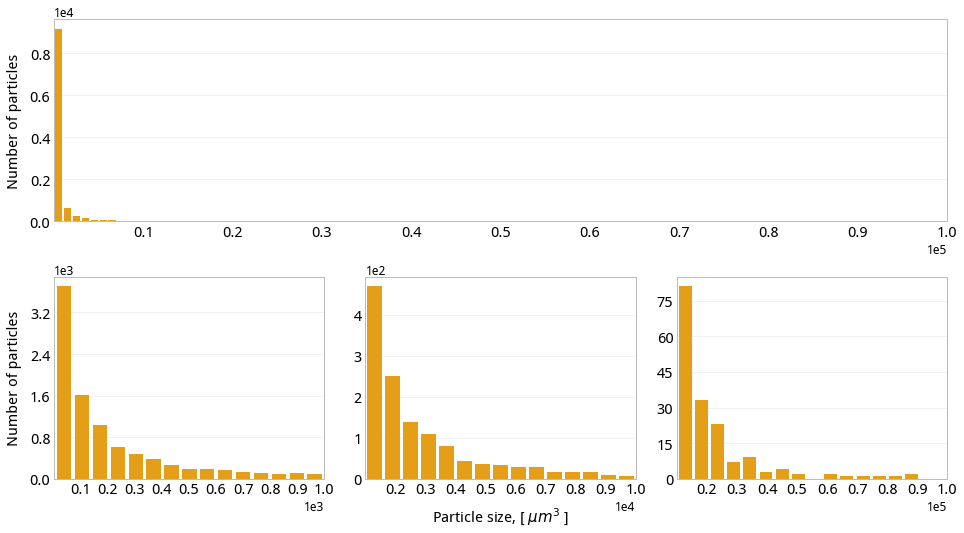

In [511]:
sample_charts_params = {
    'PCL_SiHA_cl': [ 
            {'pidx': (2,1,1),
             'range': (np.linspace(0,100000,num=101),1,100000),
             'xlabel': None,
             'ylabel': 'Number of particles',
             'color': '#e49e18' },
        
            {'pidx': (2,3,4),
             'range': (15,1,1000),
             'xlabel': None,
             'ylabel': 'Number of particles',
             'color': '#e49e18' },
        
            {'pidx': (2,3,5),
             'range': (15,1000,10000),
             'xlabel': 'Particle size, [ $\mu m^{3}$ ]',
             'ylabel': None, 
             'color': '#e49e18' },
        
            {'pidx': (2,3,6),
             'range': (15,10000,100000),
             'xlabel': None,
             'ylabel': None,
             'color': '#e49e18' }
    ]
}

plot_complex_hist('./samples/polymer_data/results',
                  sample_charts_params,
                  scale=0.5)

# Plot fiber orientation

In [85]:
def plot_orientation(dpy_path, sample_params, **kwargs):
    for key, params in sample_params.items():
        dpy = np.rad2deg(np.load(dpy_path).item()[key])
        dpy = dpy[np.where(dpy > 0)]
        
        xmin, xmax = params[1]
        N = 180
        
        theta = np.linspace(0., 2.*np.pi, N, endpoint=False)
        width = np.pi / N
        hist, bins = np.histogram(dpy, bins=theta)
        
        ax = plt.subplot(111, projection='polar')
        bars = ax.bar(theta, hist, width=width, bottom=0.0)
        
        for r, bar in zip(radii, bars):
            bar.set_facecolor(plt.cm.viridis(r / 10.))
            bar.set_alpha(0.5)

        plt.show()

In [250]:
_dpy_path = get_result_path('PCL_wa', './samples/polymer_data/results', type='o')
_data = np.load(_dpy_path).item()
print _data['azth'].shape

(251, 800, 800)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

N = 180

_dpy_path = get_result_path('PCL_wa', './samples/polymer_data/results', type='o')
_data = np.load(_dpy_path).item()

_azth = np.rad2deg(_data['azth']).flatten()
_lat = np.rad2deg(_data['lat']).flatten()

azth_vals = np.linspace(0., 179., N, endpoint=True)
lat_vals = np.linspace(-90., 89., N, endpoint=True)

azth_hist, _ = np.histogram(_azth, bins=azth_vals)
lat_hist, _ = np.histogram(_lat, bins=lat_vals)

theta = np.linspace(0., 179., N-1, endpoint=True)
radii = azth_hist
width = np.pi / 20.

ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)


plt.show()

# Plot fiber diameter

In [256]:
def create_pie_chart_figure():
    sample_name = 'PCL_wa'
    input_dir = './samples/polymer_data/results'
    title = 'PCL w/a'
    rngs = [(1, 10,), (10,25,)]
    type = 'd'
    unit_scale=1.8
    dpy_path = get_result_path(sample_name, input_dir, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    proc_diameters = [n/float(se) * 100.0 for n in num_elem]      
                      
    def get_title(v1, v2):
        return '%s $\minus$ %s $\mathregular{um^3}$' % (number(v1), number(v2))
                      
    titles = [get_title(minv, maxv) for minv,maxv in rngs]
    colors = ['#23819C', '#2FAACE', '#57BCD9', '#8CD1E6', '#B8E2EF'] #blue       
    textprops={'fontsize': 55, 'weight': 'light', 'family': 'sans-serif'}
    pie_width = 0.5
    
    fig, ax = plt.subplots(figsize=(27,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_diameters, textprops=textprops, colors=colors, \
                                       autopct='%1.1f%%', radius=1, pctdistance=1-pie_width/2)
    plt.setp(patches, width=pie_width, edgecolor='white')
    plt.text(0.5, 0.5, title, horizontalalignment='center', verticalalignment='center', \
             weight='bold', fontsize=80, transform=ax.transAxes)
    plt.legend(patches, titles, loc=(0.71,0.66), fontsize=50)
    plt.tight_layout()


In [259]:
def plot_histogram_fig(data, num_bins, xticks, splot_index=111):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(splot_index)
    n, bins, patches = ax.hist(data, 50, normed=1, color='#19B5FE', rwidth=0.8)

    mu, sigma = np.mean(data), np.std(data)
    y = mlab.normpdf(bins, mu, sigma)
    ax.plot(bins, y, '--', linewidth=2)
    
    ax.tick_params(color='black', labelcolor='black', direction='out', pad=7)
    ax.tick_params(axis='y', which='major', labelsize=30)
    ax.tick_params(axis='x', which='major', labelsize=30)
    
    pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
    plt.xticks(xticks, xticks)
        
    ax.xaxis.offsetText.set_fontsize(22)
    ax.yaxis.offsetText.set_fontsize(22)
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=22)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))

    ax.xaxis.grid(False)
    ax.yaxis.grid(lw=1, color='#aaaaaa', alpha=0.3)

    ax.set_ylabel('Amount, [a.u.]', labelpad=2, fontsize=30, color='black')
    ax.set_xlabel('Orientation', labelpad=2, fontsize=30, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    return fig, ax

In [ ]:
def plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, **kwargs):
    sample_name = 'PCL_wa'
    input_dir = './samples/polymer_data/results'
    sample_params= dict(azth=('Azimuth', (0., 180.), 50), lat=('Latitude', (-90.,90.), 25))
    
    for key, params in sample_params.items():
        dpy_path = get_result_path(sample_name, input_dir, type=type)
        dpy = np.rad2deg(np.load(dpy_path).item()[key])
        dpy = dpy[np.where(dpy > 0)]
        
        fig, ax = plot_histogram_fig(dpy,
                                 num_bins=params[2],
                                 xticks=np.linspace(params[1][0], params[1][1], num=10).astype(np.int32),
                                 xlim=params[1],
                                 **kwargs)